In [1]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
from torch.utils import data
from IPython import display
import time
from matplotlib import pyplot as plt
%matplotlib inline

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [3]:
x = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, 'output shape:\t', x.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [4]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def get_dataloader_workers():
    return 4

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

loss 0.376, train acc 0.862, test acc 0.872
748.1 examples/sec on cuda:0


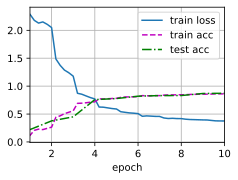

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())